# TensorFlow neural networks and evasion attacks

In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import jdc

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import numpy as np
from matplotlib import pyplot as plt

from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import FastGradientMethod, LowProFool

# Dataset
-----
### Load MNIST dataset 

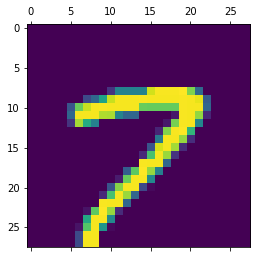

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

plt.matshow(x_train[123])
plt.show()

### Data preparation

In [3]:
x_train, x_test = x_train / 255.0, x_test / 255.0

x_train = x_train.astype(np.float32)
x_test = x_test.astype(np.float32)

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

# Neural network classifier
---
### TensorFlow model

In [4]:
class TfModel(Model):
    
    def __init__(self):
        super(TfModel, self).__init__()
        self.conv1 = Conv2D(filters=4, kernel_size=4, activation='relu')
        self.flatten = Flatten()
        self.dense1 = Dense(10, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.dense1(x)
        return x


### Neural network class for training. Metrics for training and testing

In [5]:
class NeuralNetworkTrainer():
    
    def __init__(self):
        self._model = TfModel()
        self._loss = tf.keras.losses.SparseCategoricalCrossentropy()
        self._optimizer = tf.keras.optimizers.Adam()
        
        self._train_loss = tf.keras.metrics.Mean(name='train_loss')
        self._train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

        self._test_loss = tf.keras.metrics.Mean(name='test_loss')
        self._test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')
        
    def get_classifier(self, nb_classes, input_shape):
        return TensorFlowV2Classifier(
            model          = self._model,
            nb_classes     = nb_classes,
            input_shape    = input_shape, 
            loss_object    = self._loss,               
            clip_values    = (0, 1), 
            channels_first = False
        )

### Train method 

In [6]:
%%add_to NeuralNetworkTrainer

@tf.function
def _train(self, samples, labels):
    with tf.GradientTape() as tape:
        predictions = self._model(samples)
        loss = self._loss(labels, predictions)

    gradients = tape.gradient(loss, self._model.trainable_variables)
    self._optimizer.apply_gradients(zip(gradients, self._model.trainable_variables))
    self._train_loss(loss)
    self._train_accuracy(labels, predictions)

@tf.function
def _test(self, samples, labels):
    predictions = self._model(samples)
    loss = self._loss(labels, predictions)
    self._test_loss(loss)
    self._test_accuracy(labels, predictions)

def train(self, train_ds, test_ds, epoches):
    for epoch in range(epoches):
        for samples, labels in train_ds:
            self._train(samples, labels)

        for test_samples, test_labels in test_ds:
            self._test(test_samples, test_labels)

        print('Epoch {}, Train Accuraccy: {}, Test Accurracy: {}'.format(
            epoch+1, self._train_accuracy.result(), self._test_accuracy.result()))

### Test method

In [7]:
%%add_to NeuralNetworkTrainer

def test(self, x_test, y_test):
    y_test_pred = np.argmax(self._model(x_test), axis=1)
    accuracy_test = np.sum(y_test_pred == y_test) / len(y_test)
    print('Accuracy on test data: {}'.format(accuracy_test))
    return accuracy_test

### Training and evaluating

In [8]:
nn = NeuralNetworkTrainer()
nn.train(train_ds, test_ds, epoches=5)
nn.test(x_test, y_test)

Epoch 1, Train Accuraccy: 0.916533350944519, Test Accurracy: 0.9508000016212463
Epoch 2, Train Accuraccy: 0.9360250234603882, Test Accurracy: 0.9581000208854675
Epoch 3, Train Accuraccy: 0.9462166428565979, Test Accurracy: 0.9610333442687988
Epoch 4, Train Accuraccy: 0.952791690826416, Test Accurracy: 0.9646250009536743
Epoch 5, Train Accuraccy: 0.9574666619300842, Test Accurracy: 0.9664999842643738
Accuracy on test data: 0.974


0.974

In [9]:
classifier = nn.get_classifier(10, x_train[0].shape)

# Eavsion attacks
---
### Fast Gradient Sign Method attack

Accuracy on adversarial test data: 0.02
Average perturbation: 0.17001430690288544
Before attack:


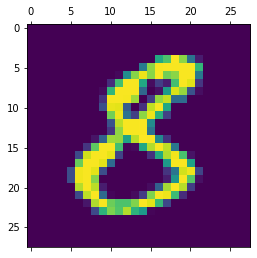

After attack:


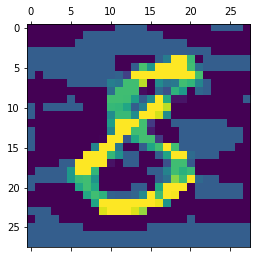

In [10]:
attack = FastGradientMethod(estimator=classifier)

x_test_adv = attack.generate(x_test)

y_test_predictions = np.argmax(classifier.model(x_test_adv), axis=1)
accuracy_test_adv = np.sum(y_test_predictions == y_test) / len(y_test)

perturbation = np.mean(np.abs((x_test_adv - x_test)))

print('Accuracy on adversarial test data: {}'.format(accuracy_test_adv))
print('Average perturbation: {}'.format(perturbation))

print('Before attack:')

plt.matshow(x_test[1234])
plt.show()

print('After attack:')

plt.matshow(x_test_adv[1234])
plt.show()

### Train neural network with adversial data

In [11]:
x_train_adv = attack.generate(x_train)

train_ds_adv = tf.data.Dataset.from_tensor_slices((x_train_adv, y_train)).shuffle(10000).batch(32)
test_ds_adv = tf.data.Dataset.from_tensor_slices((x_test_adv, y_test)).batch(32)

nn = NeuralNetworkTrainer()
nn.train(train_ds_adv, test_ds_adv, epoches=9)
nn.test(x_test_adv, y_test)

classifier_v2 = nn.get_classifier(10, x_train_adv[0].shape)

Epoch 1, Train Accuraccy: 0.9739166498184204, Test Accurracy: 0.9739000201225281
Epoch 2, Train Accuraccy: 0.9767749905586243, Test Accurracy: 0.9743000268936157
Epoch 3, Train Accuraccy: 0.9783555269241333, Test Accurracy: 0.974566638469696
Epoch 4, Train Accuraccy: 0.979604184627533, Test Accurracy: 0.9746500253677368
Epoch 5, Train Accuraccy: 0.9806633591651917, Test Accurracy: 0.9746000170707703
Epoch 6, Train Accuraccy: 0.981636106967926, Test Accurracy: 0.9745333194732666
Epoch 7, Train Accuraccy: 0.9825904965400696, Test Accurracy: 0.9745285511016846
Epoch 8, Train Accuraccy: 0.9835583567619324, Test Accurracy: 0.9746875166893005
Epoch 9, Train Accuraccy: 0.9844481348991394, Test Accurracy: 0.9746778011322021
Accuracy on test data: 0.9746


### Perform same attack on it

In [13]:
attack = FastGradientMethod(estimator=classifier_v2)

x_test_adv = attack.generate(x_test)

y_test_predictions = np.argmax(classifier.model(x_test_adv), axis=1)
accuracy_test_adv = np.sum(y_test_predictions == y_test) / len(y_test)

perturbation = np.mean(np.abs((x_test_adv - x_test)))

print('Accuracy on adversarial test data: {}'.format(accuracy_test_adv))
print('Average perturbation: {:4.2f}'.format(perturbation))

Accuracy on adversarial test data: 0.8529
Average perturbation: 0.10
